Early stopping82
Train R^2: 0.9909255914390087 - Variances: [0.00799961]
Validation R^2: 0.9923086054623127 - Variances: [0.00664321]
Test R^2: 0.9950614711269736 - Variances: [0.00596699]


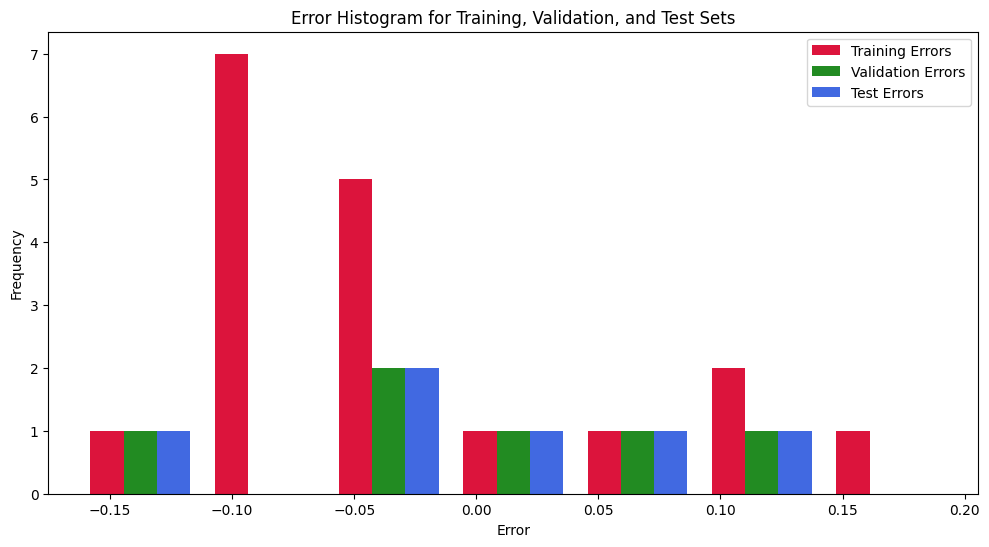

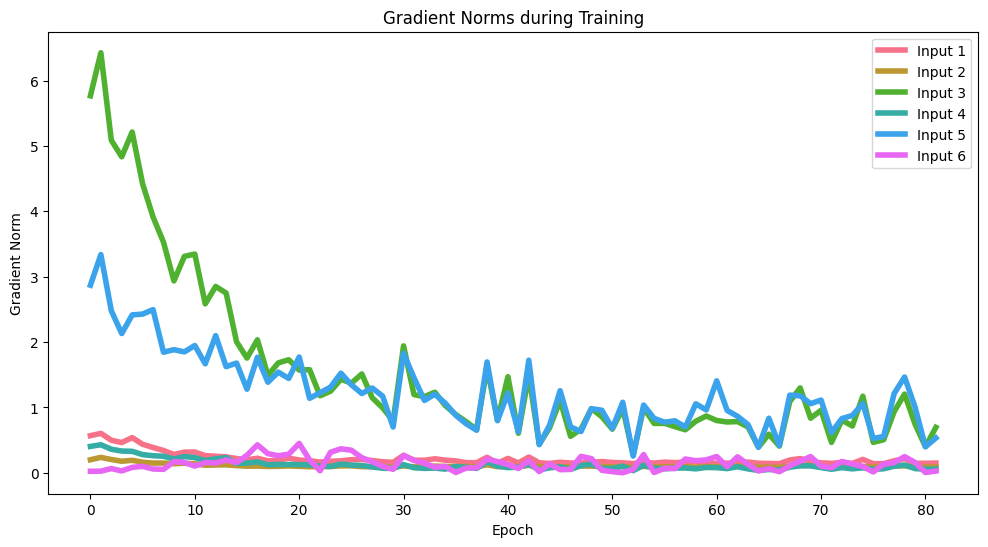

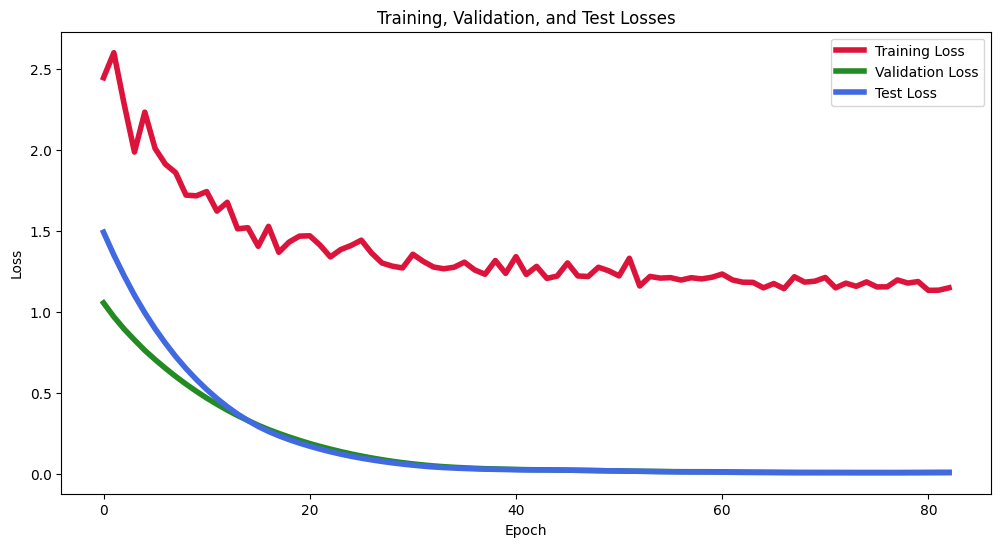

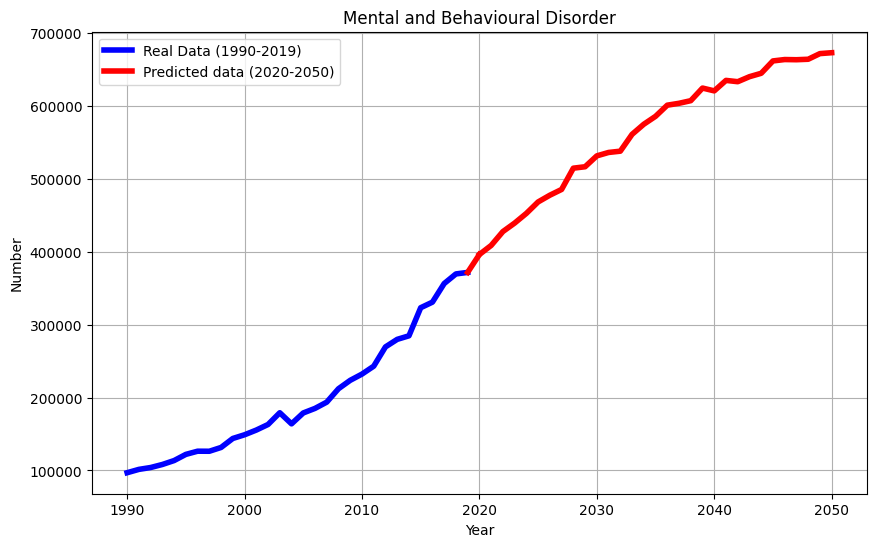

Predictions saved to '/content/drive/MyDrive/Colab Notebooks/MentalPre90-19.csv'


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Impostazione della palette di colori
sns.set_palette("husl")

# Lettura del dataset da CSV
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv')

# Nomi delle colonne
input_columns = [ 'Anthropogenic Forcing','CO2', 'CH4']  # Tutte le colonne di input
output_columns = ['Mental and Behavioural Disorder']

# Separazione delle caratteristiche e delle etichette
X = df[input_columns].values
y = df[output_columns].values

# Normalizzazione dei dati climatici
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

# Normalizzazione delle etichette
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)

# Suddivisione dei dati in training (60%), validazione (20%) e test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Conversione a tensori PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Definizione del modello con dropout
class FeedforwardNN(nn.Module):
    def __init__(self):
        super(FeedforwardNN, self).__init__()
        self.hidden = nn.Linear(3, 300)  # 3input features
        self.hidden2 = nn.Linear(300, 100)
        self.dropout = nn.Dropout(0.6)
        self.output = nn.Linear(100, 1)  # 1 output features

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = torch.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.output(x)  # Usiamo linear per output continuo
        return x

model = FeedforwardNN()

# Definizione della funzione di perdita e dell'ottimizzatore con regolarizzazione bayesiana
criterion = nn.MSELoss()
learning_rate = 0.0003  # Ridotto il learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Callback per Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Inizializzazione di Early Stopping
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

# Funzione per calcolare il numero di parametri del modello
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Addestramento del modello
num_epochs = 250
train_losses = []
val_losses = []
test_losses = []
gradients = []
num_parameters = []

alpha = 0.59  # Parametro per la regolarizzazione bayesiana
beta = 0.0125 # Parametro per la regolarizzazione bayesiana


for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Aggiunta del termine di regolarizzazione bayesiana
    reg_loss = 0
    for param in model.parameters():
        reg_loss += alpha * torch.sum(torch.log(1 + beta * torch.square(param)))
    loss += reg_loss

    loss.backward()
    optimizer.step()

    # Memorizzazione delle perdite di addestramento e di validazione
    train_losses.append(loss.item())
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())

        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping{epoch}")
        break

    # Memorizzazione dei gradienti e del numero di parametri
    gradients.append([p.grad.norm().item() for p in model.parameters()])
    num_parameters.append(count_parameters(model))

# Test del modello
model.eval()
with torch.no_grad():
    train_pred = model(X_train).numpy()
    val_pred = model(X_val).numpy()
    test_pred = model(X_test).numpy()

# Calcolo di R^2 per il training set
train_r2 = 1 - np.sum((y_train.numpy() - train_pred) ** 2) / np.sum((y_train.numpy() - np.mean(y_train.numpy())) ** 2)

# Calcolo di R^2 per il validation set
val_r2 = 1 - np.sum((y_val.numpy() - val_pred) ** 2) / np.sum((y_val.numpy() - np.mean(y_val.numpy())) ** 2)

# Calcolo di R^2 per il test set
test_r2 = 1 - np.sum((y_test.numpy() - test_pred) ** 2) / np.sum((y_test.numpy() - np.mean(y_test.numpy())) ** 2)


train_errors = y_train.numpy() - train_pred
val_errors = y_val.numpy() - val_pred
test_errors = y_test.numpy() - test_pred

# Calcolo della varianza degli errori per ogni variabile di output
train_variances = np.var(train_errors, axis=0)
val_variances = np.var(val_errors, axis=0)
test_variances = np.var(test_errors, axis=0)

print(f'Train R^2: {train_r2} - Variances: {train_variances}')
print(f'Validation R^2: {val_r2} - Variances: {val_variances}')
print(f'Test R^2: {test_r2} - Variances: {test_variances}')

# Calcolo del coefficiente di correlazione per ogni variabile di output
correlations = [np.corrcoef(y_test[:, i], y_val[:, i])[0, 1] for i in range(y_test.shape[1])]

# Definizione dei bin comuni
all_train_errors = train_errors.flatten()
all_val_errors = val_errors.flatten()
all_test_errors = test_errors.flatten()

bins = np.linspace(min(all_train_errors.min(), all_val_errors.min(), all_test_errors.min()),
                   max(all_train_errors.max(), all_val_errors.max(), all_test_errors.max()), 8)


colors=['crimson','forestgreen','royalblue','orange']
plt.rcParams['lines.linewidth'] = 4
# Plot dell'istogramma con i tre valori sullo stesso bin in colonna
plt.figure(figsize=(12, 6))
plt.hist([all_train_errors, all_val_errors, all_test_errors], bins=bins, label=['Training Errors', 'Validation Errors', 'Test Errors'], edgecolor='none', color=colors[:3] )
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Histogram for Training, Validation, and Test Sets')
plt.legend()
plt.show()

# Converting gradients list of lists into a numpy array for easier manipulation
gradients = np.array(gradients)

colors=['crimson','forestgreen','royalblue','orange','red']

# Plotting the gradients
plt.figure(figsize=(12, 6))
for i in range(gradients.shape[1]):
    plt.plot(gradients[:, i], label=f'Input {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms during Training')
plt.legend()
plt.show()

# Plotting the training, validation, and test losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color=colors[0])
plt.plot(val_losses, label='Validation Loss', color=colors[1])
plt.plot(test_losses, label='Test Loss', color=colors[2])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Losses')
plt.legend()
plt.show()



new_data_file_path = '/content/drive/MyDrive/Colab Notebooks/dati2050.csv'
new_df = pd.read_csv(new_data_file_path)

# Ensure the new data has the same columns as the training data
new_X = new_df[input_columns].values

# Normalize the new data using the fitted scaler
new_X = scaler_X.transform(new_X)

# Convert the new data to PyTorch tensors
new_X_tensor = torch.tensor(new_X, dtype=torch.float32)

# Predict using the model
with torch.no_grad():
    predictions = model(new_X_tensor)

# Inverse transform the predictions if they were normalized during training
predictions = scaler_y.inverse_transform(predictions.numpy())
pred_df = pd.DataFrame(predictions, columns=['Predicted Mental and Behavioural Disorder'])

pred_df.to_csv('predictions2050.csv', index=False)

x1 = np.arange(1990, 2020)
x2 = np.arange(2020, 2051)
x3 = np.arange(2019,2021)
nuovo_array = np.array([df.at[29, 'Mental and Behavioural Disorder'], pred_df.at[0, 'Predicted Mental and Behavioural Disorder']])

# Traccia le rette in sequenza
plt.figure(figsize=(10, 6))
plt.plot(x1,df['Mental and Behavioural Disorder'], label='Real Data (1990-2019)', color='blue')
plt.plot(x2,pred_df['Predicted Mental and Behavioural Disorder'], label='Predicted data (2020-2050)', color='red')
plt.plot(x3,nuovo_array , color='red')
plt.xlabel('Year')
plt.ylabel('Number')
plt.title('Mental and Behavioural Disorder')
plt.legend()
plt.grid(True)
plt.show()


old_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv')
old_X = old_df[input_columns].values

# Normalize the new data using the fitted scaler
old_X = scaler_X.transform(old_X)

# Convert the new data to PyTorch tensors
old_X_tensor = torch.tensor(old_X, dtype=torch.float32)

# Predict using the model
with torch.no_grad():
    predictions = model(old_X_tensor)

# Inverse transform the predictions if they were normalized during training
predictions = scaler_y.inverse_transform(predictions.numpy())

pred_df = pd.DataFrame(predictions, columns=['Predicted Mental and Behavioural Disorder'])
pred_df.to_csv('/content/drive/MyDrive/Colab Notebooks/MentalPre90-19.csv', index=False)
print("Predictions saved to '/content/drive/MyDrive/Colab Notebooks/MentalPre90-19.csv'")
